# OpenSCM Timeseries

Like in everyday usage, a timeseries in OpenSCM is a series of data points associated with specific points in time i.e. discrete data. 

In this notebook, we call the values used to initialise the timeseries the 'source data' and the times with which they are associated the 'source times'.

To estimate the value of the variable under consideration at points in time other than the source points (call these points the 'target times'), i.e. to interpolate or extrapolate, we always take the following steps:

1. start with the data which was originally used to set the timeseries
1. convert the discrete data to continuous data using an interpolation/extrapolation technique
    - e.g. linear interpolation, cubic spline, moving average
1. use the continuous data to determine the values at the target times aka the 'target values'

There is one additional complication in this process. It is the different conventions that are used with timeseries. For example, sometimes the data value is the value only at the exact point in time for which it is supplied (we call this 'point' data) while other times the data value represents the average of the underlying continuous data set over a given time period (we call this 'average' data). These conventions affect how the conversion between continuous and discrete data is done and hence are vital to document and understand.

*Note:* In order to recover the original data from the target data, you need to know which assumptions have been made in the interpolation process and what convention is being used.

In this notebook we go through the different interpolation and extrapolation options available to OpenSCM users as well as the different conventions OpenSCM understands. If your particular use case is not here, please raise an issue at [https://github.com/openclimatedata/openscm/issues]().

In [2]:
import datetime as dt

from openscm.scmdataframe import ScmDataFrame
from openscm.utils import convert_datetime_to_openscm_time, convert_openscm_time_to_datetime



from itertools import count
from copy import copy
import re
import traceback

import numpy as np
import scipy.interpolate as interpolate
import scipy.integrate as integrate




from openscm.errors import InsufficientDataError
from openscm.core import ParameterSet
from openscm.parameters import ParameterType
from openscm.timeseries_converter import (
    _calc_interval_averages,
    create_time_points,
    InterpolationType,
    ExtrapolationType,
    TimeseriesConverter,
)

In [3]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
COLOUR_1 = "lime"
COLOUR_2 = "midnightblue"
COLOUR_3 = "firebrick"
COLOUR_4 = "deeppink"

MARKER_1 = "o"
MARKER_2 = "x"
MARKER_3 = "+"
MARKER_4 = "^"

## Holding data

OpenSCM's high-level data structure is the `ScmDataFrame`. It requires certain metadata to always be included hence we use 'example' throughout this notebook. For more information on this class, see the 'scmdataframe' notebook or the docs.

The `ScmDataFrame` stores information about whether the timeseries is a 'point' (each data point ) or 'average' (each data point  timeseries in a column called `parameter_type`. If this column is missing, `ScmDataFrame` will guess what kind of timeseries it is based off the variable name and the unit (we show an example of this alter). 

As a reminder, each data value in a 'point' timeseries represents the value of the quantity at the given timepoint only while each data value in an 'average' timeseries represents the average value of the quantity over the period between its timepoint and the next one. The distinction and its implications will become clearer throughout the course of the notebook.

---
## Example 1: Point data without extrapolation

The simplest and most familiar case is handling point data i.e. data which represents the value of a quantity at an exact point in time.

### Source data

To start with, we set our source data.

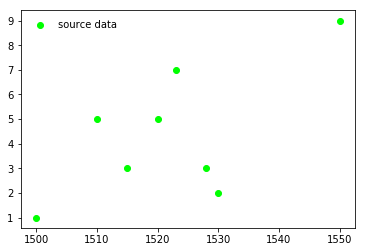

In [5]:
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])
source_times = [
    dt.datetime(y, 1, 1) 
    for y in [1500, 1510, 1515, 1520, 1523, 1528, 1530, 1550]
]

ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source data",
)
ax.legend(frameon=False);

### Target data

Next we set our target times.

In [6]:
target_times = [
    dt.datetime(y, 1, 1) 
    for y in [1505, 1510, 1520, 1530, 1540, 1545, 1550]
]

### Conversion

Below, we show what happens under the hood in OpenSCM.

To convert from discrete to continuous data, we interpolate the data to a continuous function using scipy's interpolate module. To do this, we must firstly convert all the datetimes to seconds.

*Note:* At the moment, we only offer linear interpolation. In future we intend to add a cubic interpolation option.

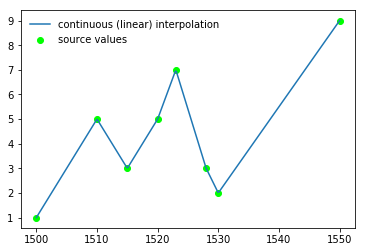

In [7]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source values",
)

source_times_int = [convert_datetime_to_openscm_time(t) for t in source_times]
fine_times = np.linspace(source_times_int[0], source_times_int[-1], 300)
interp = interpolate.interp1d(source_times_int, source_values)
ax.plot(
    [convert_openscm_time_to_datetime(t) for t in fine_times],
    interp(fine_times),
    label="continuous (linear) interpolation",
)

ax.legend(frameon=False);

In a second step, we calculate the target values by determining the value of the interpolated function at the target times. 

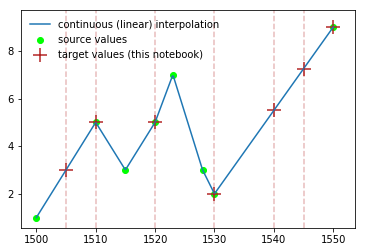

In [8]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source values",
)

ax.plot(
    [convert_openscm_time_to_datetime(t) for t in fine_times],
    interp(fine_times),
    label="continuous (linear) interpolation",
)


ax.scatter(
    target_times,
    interp([convert_datetime_to_openscm_time(t) for t in target_times]),
    color=COLOUR_3,
    marker=MARKER_3,
    label="target values (this notebook)",
    s=200,
)

for x in target_times[:-1]:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
    
ax.legend(frameon=False);

The simplest way to do such interpolations with OpenSCM is with the `ScmDataFrame`.

In [9]:
source_data = ScmDataFrame(
    source_values,
    index=source_times,
    columns={
        "model": "example",
        "scenario": "example",
        "region": "World",
        "variable": "Atmospheric Concentrations|HFC32",
        "unit": "ppt",
        "parameter_type": "point",
    }
)
source_data.timeseries()

,,,,,time,1500-01-01 00:00:00,1510-01-01 00:00:00,1515-01-01 00:00:00,1520-01-01 00:00:00,1523-01-01 00:00:00,1528-01-01 00:00:00,1530-01-01 00:00:00,1550-01-01 00:00:00
model,scenario,region,variable,unit,parameter_type,,,,,,,,
example,example,World,Atmospheric Concentrations|HFC32,ppt,point,1.0,5.0,3.0,5.0,7.0,3.0,2.0,9.0


In [10]:
target_data = source_data.interpolate(target_times)
target_data.timeseries()

,,,,,time,1505-01-01 00:00:00,1510-01-01 00:00:00,1520-01-01 00:00:00,1530-01-01 00:00:00,1540-01-01 00:00:00,1545-01-01 00:00:00,1550-01-01 00:00:00
model,scenario,region,variable,unit,parameter_type,,,,,,,
example,example,World,Atmospheric Concentrations|HFC32,ppt,point,3.0,5.0,5.0,2.0,5.499521,7.25024,9.0


We compare the output of OpenSCM and our minimal working example in the cell below.

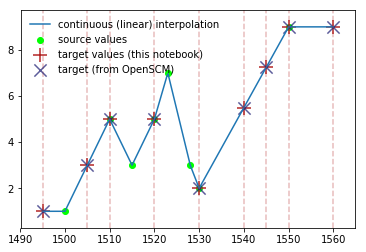

In [26]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source values",
)

ax.plot(
    [convert_openscm_time_to_datetime(t) for t in fine_times],
    interp(fine_times),
    label="continuous (linear) interpolation",
)


ax.scatter(
    target_times,
    interp([convert_datetime_to_openscm_time(t) for t in target_times]),
    color=COLOUR_3,
    marker=MARKER_3,
    label="target values (this notebook)",
    s=200,
)

ax.scatter(
    target_data.timeseries().columns,
    target_data.timeseries().values,
    marker=MARKER_2,
    color=COLOUR_2,
    alpha=0.7,
    label="target (from OpenSCM)",
    s=150,
)

for x in target_times:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
    
ax.legend(frameon=False);

As we would hope, and can check below, our OpenSCM implementation produces the same results as the minimal example we have just been through.

In [27]:
np.testing.assert_allclose(
    interp([convert_datetime_to_openscm_time(t) for t in target_times]),
    target_data.timeseries().values.squeeze()
)

---
## Example 2: Point data with extrapolation

It is possible to automatically extrapolate the data using OpenSCM.

### Source data

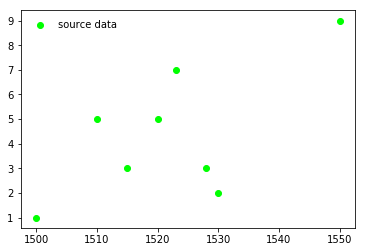

In [28]:
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])
source_times = [
    dt.datetime(y, 1, 1) 
    for y in [1500, 1510, 1515, 1520, 1523, 1528, 1530, 1550]
]

ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source data",
)
ax.legend(frameon=False);

In [29]:
source_data = ScmDataFrame(
    source_values,
    index=source_times,
    columns={
        "model": "example",
        "scenario": "example",
        "region": "World",
        "variable": "Atmospheric Concentrations|HFC32",
        "unit": "ppt",
        "parameter_type": "point",
    }
)
source_data.timeseries()

,,,,,time,1500-01-01 00:00:00,1510-01-01 00:00:00,1515-01-01 00:00:00,1520-01-01 00:00:00,1523-01-01 00:00:00,1528-01-01 00:00:00,1530-01-01 00:00:00,1550-01-01 00:00:00
model,scenario,region,variable,unit,parameter_type,,,,,,,,
example,example,World,Atmospheric Concentrations|HFC32,ppt,point,1.0,5.0,3.0,5.0,7.0,3.0,2.0,9.0


### Target data and conversion

Using different extrapolation types, we can get different results. This process is sufficiently trivial that we can illustrate how it works for a variety of cases, both using our underlying tools and using OpenSCM, in the cell below.

In [30]:
target_times = [
    dt.datetime(y, 1, 1) 
    for y in [1495, 1505, 1510, 1520, 1530, 1540, 1545, 1550, 1560]
]

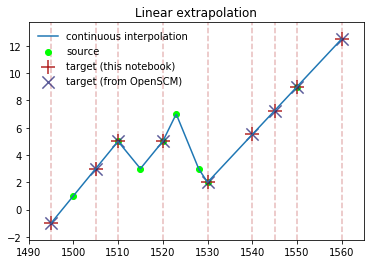

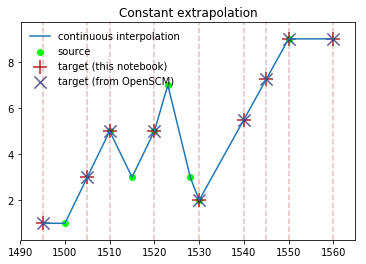

In [33]:
examples = [
    (
        "Linear extrapolation",  # name
        ExtrapolationType.LINEAR,  # extrapolation type, comes from OpenSCM.timeseries_converter
        {"fill_value": "extrapolate"}  # arguments passed to numpy to do this type of extrapolation
    ),
    (
        "Constant extrapolation", 
        ExtrapolationType.CONSTANT, 
        {"fill_value": (source_values[0], source_values[-1]), "bounds_error": False}
    ),
]
for (title, extrap_type, numpy_kwargs) in examples:
    target_data = source_data.interpolate(
        target_times,
        interpolation_type=InterpolationType.LINEAR,
        extrapolation_type=extrap_type,
    )

    ax = plt.figure().add_subplot(111)
    ax.scatter(
        source_times,
        source_values,
        marker=MARKER_1,
        color=COLOUR_1,
        label="source",
    )
    
    source_times_int = [convert_datetime_to_openscm_time(t) for t in source_times]
    interp = interpolate.interp1d(
        source_times_int,
        source_values,
        **numpy_kwargs
    )
    
    target_times_int = [convert_datetime_to_openscm_time(t) for t in target_times]
    fine_times = np.linspace(target_times_int[0], target_times_int[-1], 300)
    ax.plot(
        [convert_openscm_time_to_datetime(t) for t in fine_times],
        interp(fine_times),
        label="continuous interpolation",
    )
    ax.scatter(
        target_times,
        interp(target_times_int),
        color=COLOUR_3,
        marker=MARKER_3,
        label="target (this notebook)",
        s=200,
    )
    ax.scatter(
        target_data.timeseries().columns,
        target_data.timeseries().values,
        marker=MARKER_2,
        color=COLOUR_2,
        alpha=0.7,
        label="target (from OpenSCM)",
        s=150,
    )
    ax.legend(frameon=False)
    for x in target_times:
        ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
        
    ax.set_title(title);

If you try to extrapolate with the extrapolation type set to `ExtrapolationType.NONE` then you will receive an `InsufficientDataError`.

In [35]:
try:
    source_data.interpolate(
        target_times,
        interpolation_type=InterpolationType.LINEAR,
        extrapolation_type=ExtrapolationType.NONE,
    )
except InsufficientDataError as e:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
openscm.errors.InsufficientDataError: ('Target time points are outside the source time points, use an extrapolation type other than None', 'occurred at index 0')


---
## Example 3: Period average data with linear interpolation

The most complex case OpenSCM can handle is linear interpolation of data where the convention is that the source values represent the average of the underlying timeseries over a time period. This time period extends from the time time at which the value is provided, the 'data time', up until the next time in the timeseries. A common example for such a convention is emissions data, where each time point represents the average emissions flux for that time period e.g. 2100 emissions of 3 GtC / yr means that the average rate of emissions for 2100 was 3 GtC / yr.

<div class="alert alert-warning">
  <strong>Warning!</strong> Emissions data is ocassionally reported without the rate e.g. 2100 emissions were 3 GtC. Before passing emissions data into OpenSCM it should have the units converted to rates (of course, cumulative emissions data should not be reported as rates and so perhaps the only fix required is changing the variable name from `Emissions` to `Cumulative Emissions`).
</div>

### Source data

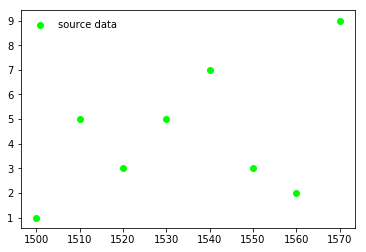

In [63]:
source_values = np.array([1, 5, 3, 5, 7, 3, 2, 9])
source_times = [
    dt.datetime(y, 1, 1) 
    for y in [1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570]
]

ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source data",
)
ax.legend(frameon=False);

Whilst these are the points in our data, when we consider average data, we are actually, in some sense, assuming that the continuous representation of the data would look like a series of steps i.e. like the following plot.

In [124]:
def plot_timeframe(ax, times, values, **kwargs):
    last_bound = times[-1] + (times[-1] - times[-2])
    times_extended = np.concatenate(([times, [last_bound]]))
    values_extended = np.concatenate(([values[0]], values))
    ax.step(times_extended, values_extended, **kwargs)

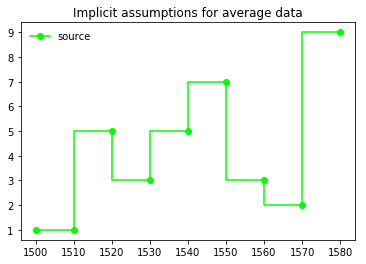

In [125]:
ax = plt.figure().add_subplot(111)
plot_timeframe(
    ax, 
    source_times,
    source_values,
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
ax.legend(frameon=False)
ax.set_title("Implicit assumptions for average data");

### Target data

In [109]:
target_times = [
    dt.datetime(y, 1, 1) 
    for y in [1497, 1504, 1511, 1518, 1525, 1532, 1539, 1546, 1553, 1560, 1567, 1574]
]

### Conversion

To convert from discrete to continuous data, we interpolate the data such that their average (i.e. integral over the period divided by the period length) equals the original source data. This ensures that we preserve the total quantity of these variables, which are often flux variables that are subject to conservation laws (e.g. emissions or energy flows).

To do the conversion, we use three points per period. Firstly, at each period edge the continuous value is assumed to equal the average of the discrete values for the two adjacent periods. Secondly, at the period mid point of each target period, the continuous value is adjusted such that the period average equals the source data value for that period (hence preserving the integral). Finally, for the first and the last period the mid points are assumed to be at the period average and the outer edges are adjusted accordingly.

In order to have well-bounded periods, we must make an assumption about how long the last time period is. Without it, our data points aren't properly bounded and so the average doesn't make any sense. Unfortunately, this assumption is rarely documented and so we must make our own best guess. In OpenSCM, we always make the assumption that the last period has the same length as the period before it. 

We provide the calculation and code to do this below. It may be best to skip to the overview plot before looking at the steps in detail.

The code which does the continuous calculation can be found in `openscm.timeseries_converter.TimeseriesConverter._calc_continous_representation`. We do not repeat the code here, but merely show its results.

In [126]:
source_times_int = np.array([convert_datetime_to_openscm_time(t) for t in source_times])
assumed_source_time_bounds = np.concatenate([
    source_times_int,
    [2*source_times_int[-1] - source_times_int[-2]]
])

target_times_int = np.array([convert_datetime_to_openscm_time(t) for t in target_times])
assumed_target_time_bounds = np.concatenate([
    target_times_int,
    [2*target_times_int[-1] - target_times_int[-2]]
])

converter = TimeseriesConverter(
    assumed_source_time_bounds,
    assumed_target_time_bounds,
    timeseries_type=ParameterType.AVERAGE_TIMESERIES,
    interpolation_type=InterpolationType.LINEAR,
    extrapolation_type=ExtrapolationType.LINEAR,
)

continuous = converter._calc_continuous_representation(
    assumed_time_bounds,
    source_values,
)

The plot below illustrates the net result.

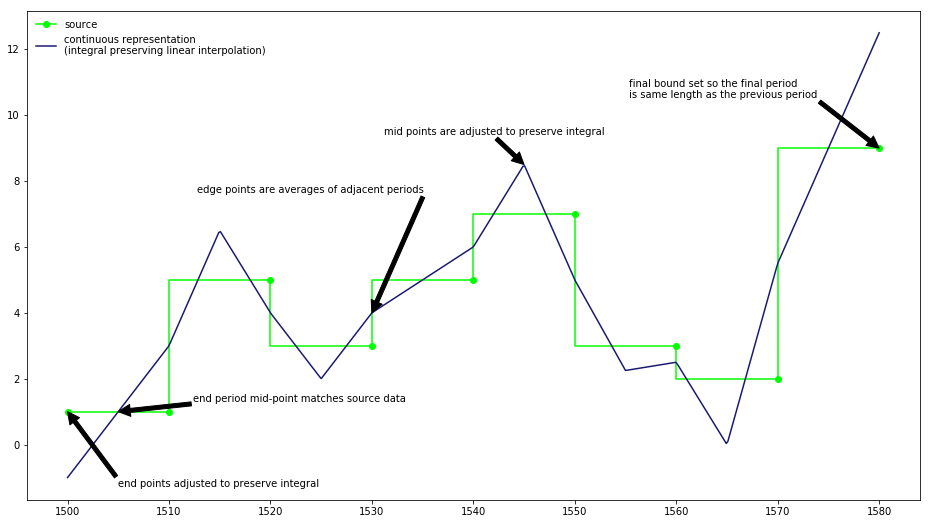

In [188]:
ax = plt.figure(figsize=(16, 9)).add_subplot(111)
plot_timeframe(
    ax, 
    source_times,
    source_values,
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
plt_times = np.linspace(
    assumed_source_time_bounds[0],
    assumed_source_time_bounds[-1],
    500
)
ax.plot(
    [convert_openscm_time_to_datetime(t) for t in plt_times], 
    continuous(plt_times), 
    label="continuous representation\n(integral preserving linear interpolation)",
    marker=None,
    color=COLOUR_2,
)
ax.legend(frameon=False)

plt.annotate(
    "edge points are averages of adjacent periods", 
    (source_times[3], (source_values[2] + source_values[3]) / 2),
    (-175, 120),
    textcoords='offset points',
    arrowprops=dict(facecolor='black'),
)

mid_point_time = source_times[4] + (source_times[5] - source_times[4]) / 2
plt.annotate(
    "mid points are adjusted to preserve integral", 
    (mid_point_time, continuous(convert_datetime_to_openscm_time(mid_point_time))),
    (-140, 30),
    textcoords='offset points',
    arrowprops=dict(facecolor='black'),
)

plt.annotate(
    "final bound set so the final period\nis same length as the previous period", 
    (convert_openscm_time_to_datetime(plt_times[-1]), source_values[-1]),
    (-250, 50),
    textcoords='offset points',
    arrowprops=dict(facecolor='black'),
)

end_point_time = source_times[0] + (source_times[1] - source_times[0]) / 2
plt.annotate(
    "end period mid-point matches source data", 
    (end_point_time, continuous(convert_datetime_to_openscm_time(end_point_time))),
    (75, 10),
    textcoords='offset points',
    arrowprops=dict(facecolor='black'),
)

plt.annotate(
    "end points adjusted to preserve integral", 
    (convert_openscm_time_to_datetime(plt_times[0]), source_values[0]),
    (50, -75),
    textcoords='offset points',
    arrowprops=dict(facecolor='black'),
);

In a second step, we calculate the target values by determining the interval averages for each target time period. (In practice, we integrate the continuous function and then divide by the time period length: code can be found in `openscm.timeseries_converter._calc_interval_averages`).

In [189]:
interval_times = assumed_target_time_bounds
interval_averages = _calc_interval_averages(
    continuous,
    interval_times
)

Under the hood, OpenSCM does the integration in the following way:

In [190]:
integrals = [np.nan] * len(interval_times[:-1])
for i, l in enumerate(interval_times[:-1]):
    u = interval_times[i + 1]
    y, _ = integrate.quad(continuous, l, u)
    integrals[i] = y

The plot below shows the final result from source values, to continous represenation to target values. On the second plot, we show how the integral of the continuous representation evolves over time.

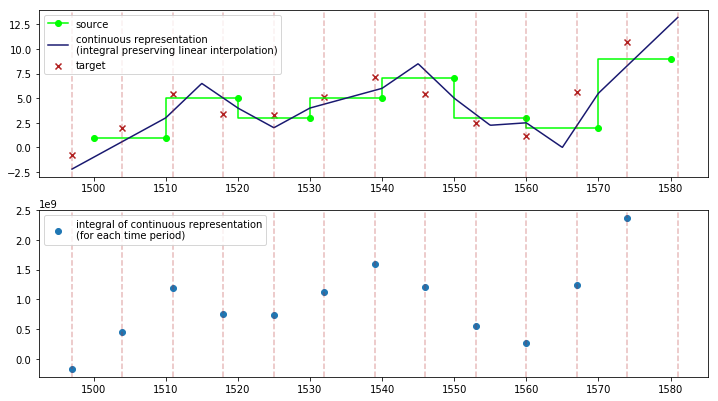

In [192]:
fig = plt.figure(figsize=(12, 6.75))
ax = fig.add_subplot(211)
plot_timeframe(
    ax,
    source_times,
    source_values,
    label="source",
    marker=MARKER_1,
    color=COLOUR_1,
)
plt_times = np.linspace(
    assumed_target_time_bounds[0],
    assumed_target_time_bounds[-1],
    500,
)
ax.plot(
    [convert_openscm_time_to_datetime(t) for t in plt_times],
    continuous(plt_times),
    label="continuous representation\n(integral preserving linear interpolation)",
    marker=None,
    color=COLOUR_2,
)
ax.scatter(
    target_times,
    interval_averages,
    color=COLOUR_3,
    marker=MARKER_2,
    label="target",
)
for x in target_times:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
ax.axvline(x=x + (target_times[-1] - target_times[-2]), color=COLOUR_3, alpha=0.3, ls="--")

ax.legend();


ax = fig.add_subplot(212, sharex=ax)
ax.scatter(
    target_times,
    integrals,
    label="integral of continuous representation\n(for each time period)",
)
for x in target_times:
    ax.axvline(x=x, color=COLOUR_3, alpha=0.3, ls="--")
ax.axvline(x=x + (target_times[-1] - target_times[-2]), color=COLOUR_3, alpha=0.3, ls="--")

ax.legend();

In the plot below, we show the result, without all the intermediate steps.

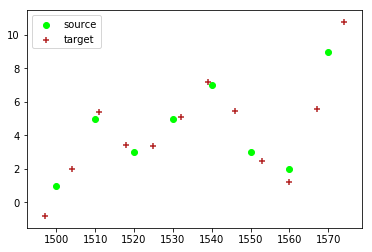

In [196]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source",
)
ax.scatter(
    target_times,
    interval_averages,
    color=COLOUR_3,
    marker=MARKER_3,
    label="target",
)
ax.legend();

### Using OpenSCM

OpenSCM handles all this for us. By setting `parameter_type` to 'average', all of this logic is applied automatically.

In [197]:
source_data = ScmDataFrame(
    source_values,
    index=source_times,
    columns={
        "model": "example",
        "scenario": "example",
        "region": "World",
        "variable": "Emissions|CO2",
        "unit": "GtC/yr",
        "parameter_type": "average",
    }
)
source_data.timeseries()

,,,,,time,1500-01-01 00:00:00,1510-01-01 00:00:00,1520-01-01 00:00:00,1530-01-01 00:00:00,1540-01-01 00:00:00,1550-01-01 00:00:00,1560-01-01 00:00:00,1570-01-01 00:00:00
model,scenario,region,variable,unit,parameter_type,,,,,,,,
example,example,World,Emissions|CO2,GtC/yr,average,1.0,5.0,3.0,5.0,7.0,3.0,2.0,9.0


In [201]:
target_data = source_data.interpolate(
    target_times,
    interpolation_type=InterpolationType.LINEAR,
    extrapolation_type=ExtrapolationType.LINEAR,
)
target_data.timeseries()

,,,,,time,1497-01-01 00:00:00,1504-01-01 00:00:00,1511-01-01 00:00:00,1518-01-01 00:00:00,1525-01-01 00:00:00,1532-01-01 00:00:00,1539-01-01 00:00:00,1546-01-01 00:00:00,1553-01-01 00:00:00,1560-01-01 00:00:00,1567-01-01 00:00:00,1574-01-01 00:00:00
model,scenario,region,variable,unit,parameter_type,,,,,,,,,,,,
example,example,World,Emissions|CO2,GtC/yr,point,-0.80011,2.020852,5.378381,3.427962,3.342887,5.099945,7.185921,5.446066,2.496295,1.207104,5.592513,10.749521


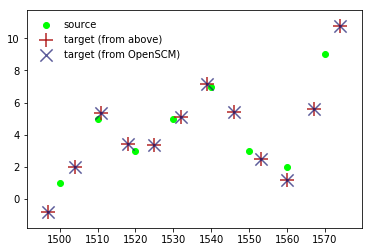

In [202]:
ax = plt.figure().add_subplot(111)
ax.scatter(
    source_times,
    source_values,
    marker=MARKER_1,
    color=COLOUR_1,
    label="source",
)
ax.scatter(
    target_times,
    interval_averages,
    color=COLOUR_3,
    marker=MARKER_3,
    label="target (from above)",
    s=200,
)
ax.scatter(
    target_data.timeseries().columns,
    target_data.timeseries().values,
    marker=MARKER_2,
    color=COLOUR_2,
    alpha=0.7,
    label="target (from OpenSCM)",
    s=150,
)
ax.legend(frameon=False);

This result may seem non-intuitive at a first glance, but is due to the preservation of the integrals and, thus, different to a more intuitive linear interpolation.

## Example 4: Guessing timeseries type

If we do not provide the `parameter_type` column, OpenSCM will guess the parameter type for us. Full details of how the guessing works can be found in the documentation of `openscm.scmdataframe.parameter_type`.

For example, Emissions timeseries are assumed to be 'average' timeseries. 

In [203]:
source_data = ScmDataFrame(
    source_values,
    index=source_times,
    columns={
        "model": "example",
        "scenario": "example",
        "region": "World",
        "variable": "Emissions|CO2",
        "unit": "GtC/yr",
    }
)

target_data = source_data.interpolate(
    target_times,
    interpolation_type=InterpolationType.LINEAR,
    extrapolation_type=ExtrapolationType.LINEAR,
)
target_data.timeseries()

`parameter_type` metadata not available. Guessing parameter types where unavailable.


,,,,,time,1497-01-01 00:00:00,1504-01-01 00:00:00,1511-01-01 00:00:00,1518-01-01 00:00:00,1525-01-01 00:00:00,1532-01-01 00:00:00,1539-01-01 00:00:00,1546-01-01 00:00:00,1553-01-01 00:00:00,1560-01-01 00:00:00,1567-01-01 00:00:00,1574-01-01 00:00:00
model,scenario,region,variable,unit,parameter_type,,,,,,,,,,,,
example,example,World,Emissions|CO2,GtC/yr,point,-0.80011,2.020852,5.378381,3.427962,3.342887,5.099945,7.185921,5.446066,2.496295,1.207104,5.592513,10.749521


Concentration timeseries are assumed to be 'point' timeseries.

In [204]:
source_data = ScmDataFrame(
    source_values,
    index=source_times,
    columns={
        "model": "example",
        "scenario": "example",
        "region": "World",
        "variable": "Atmospheric Concentrations|CO2",
        "unit": "ppm",
    }
)

target_data = source_data.interpolate(
    target_times,
    interpolation_type=InterpolationType.LINEAR,
    extrapolation_type=ExtrapolationType.LINEAR,
)
target_data.timeseries()

,,,,,time,1497-01-01 00:00:00,1504-01-01 00:00:00,1511-01-01 00:00:00,1518-01-01 00:00:00,1525-01-01 00:00:00,1532-01-01 00:00:00,1539-01-01 00:00:00,1546-01-01 00:00:00,1553-01-01 00:00:00,1560-01-01 00:00:00,1567-01-01 00:00:00,1574-01-01 00:00:00
model,scenario,region,variable,unit,parameter_type,,,,,,,,,,,,
example,example,World,Atmospheric Concentrations|CO2,ppm,point,-0.199343,2.599124,4.80011,3.399781,4.000274,5.399781,6.80011,4.599781,2.69989,2.0,6.899808,11.799617
